# Gibbs sampling

Gibbs sampling consists in replacing a simulation of $d$-dimensional random variables with $d$ independent $1$-dimensional random variables. This requires the knowledge of the marginal distributions of each component given all the others, which isn't necessarily easy. However, in the case of Gaussian distributions, this is quite straightforward. Indeed we have:

$ \pi(x \mid x_{-i}) \sim N \left( - V_{ii}^{-1} \sum_{j \not = i} V_{ij}x_j, V_{ii}^{-1} \right).$

We can write the sum a bit differently:

$ - V_{ii}^{-1} \sum_{j \not = i} V_{ij}x_j = - V_{ii}^{-1} \left( \sum_{j} V_{ij}x_j - V_{ii} x_i \right) = - V_{ii}^{-1} (Vx)_i + x_i.$

In Gibbs sampling, we simulate the new coordinate for $x_i$ according to the distribution above, which means we simply have to add to the former $x_i$ a Gaussian $N \left( - V_{ii}^{-1} (Vx)_i, V_{ii}^{-1} \right)$

We start by some imports.

In [51]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
% matplotlib inline
% matplotlib notebook
import ipywidgets as widgets
from IPython.display import display

## Simple example
We first take an example in two dimensions, which will show the steps that takes the Gibbs sampler.

In [52]:
example_V = np.array([[5,4.5],[4.5,5]])
display(example_V)
display(np.linalg.inv(example_V))

array([[ 5. ,  4.5],
       [ 4.5,  5. ]])

array([[ 1.05263158, -0.94736842],
       [-0.94736842,  1.05263158]])

We display here the density of the distribution, up to a multiplicative constant (the Gibbs sampling methid doesn't require its knowledge).

In [53]:
def pi(x,mean=np.zeros(2),V=example_V):
    return np.exp(-.5*np.dot(x,np.dot(V,x)))

<IPython.core.display.Javascript object>


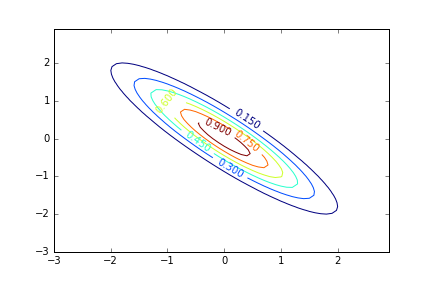

In [54]:
x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.array([[pi(np.array([X[i,j],Y[i,j]]),V=example_V) for j in range(len(X[0]))] for i in range(len(X))])
fig1 = plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10);

In [55]:
def gibbsSampler(n,x0=np.zeros(2),V=example_V):
    d = len(x0)
    trajectory = [x0]
    additional_steps = []
    x = np.copy(x0)
    for k in range(1,n):
        for i in range(d):
            Vii_inv = 1./V[i,i]
            mean_i = - Vii_inv*np.dot(V[i,:],x)
            x[i] += np.random.normal(mean_i,Vii_inv)
            if i == d-1:
                trajectory += [np.copy(x)]
            else:
                additional_steps += [np.copy(x)]
    return np.array(trajectory), np.array(additional_steps)

The program above privides the Gibbs sample and the intermediary steps used for its computation.

<IPython.core.display.Javascript object>


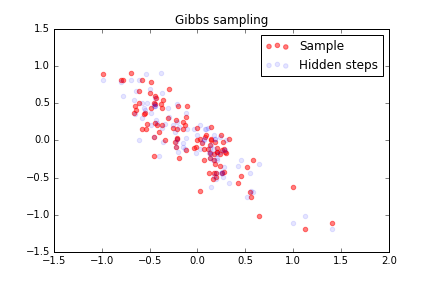

In [56]:
fig2 = plt.figure()
sample, steps = gibbsSampler(100)
plt.scatter(sample[:,0],sample[:,1],color='red',label='Sample',alpha=.5)
plt.scatter(steps[:,0],steps[:,1],color='blue',label='Hidden steps',alpha=.1)
plt.legend(loc='best')
plt.title('Gibbs sampling')

Let's see how this happens step by step. We use for this ipywidgets:

<IPython.core.display.Javascript object>


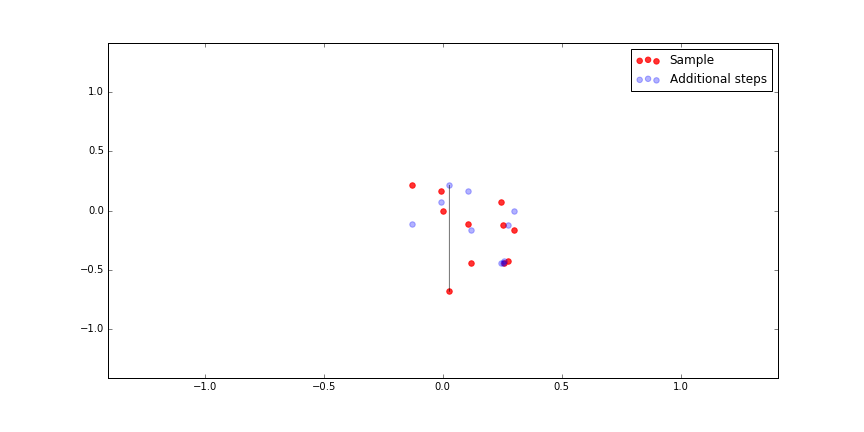

IntSlider(value=0)

Button(description=u'Advance', style=ButtonStyle())

In [76]:
def start_scatter_first(sample,steps):
    fig = plt.figure(figsize=(12,6))
    lim = np.max(np.abs(np.append(sample,steps)))
    plt.xlim((-lim, lim))
    plt.ylim((-lim, lim))
    plt.scatter([],[],alpha=.8,label='Sample',color='red',s=30)
    plt.scatter([],[],alpha=.3,label='Additional steps',color='blue',s=30)
    plt.legend(loc='best')
    plt.show()
    return fig

fig3 = start_scatter_first(sample,steps)

def update_scatter_first(n,sample,steps,figure):
    d = len(sample[0])
    sm = sample[:((1+n)/d)]
    st = steps[:(n-(1+n)/d)]
    plt.figure(figure.number)
    pc1, pc2 = figure.axes[0].collections
    pc1.set_offsets(sm)
    pc2.set_offsets(st)
    
def draw_arrow(n,sample,steps,figure):
    d = len(sample[0])
    sm = sample[:((1+n)/d)]
    st = steps[:(n-(1+n)/d)]
    plt.figure(figure.number)
    last_in_sm = ((1+n)%d == 0)
    before_last_in_sm = (n%d == 0)
    w = .000001
    alph=.5
    figure.axes[0].artists = []
    if last_in_sm:
        plt.arrow(st[-1][0],st[-1][1],sm[-1][0]-st[-1][0],sm[-1][1]-st[-1][1],width=w,alpha=alph)
    elif before_last_in_sm:
        plt.arrow(sm[-1][0],sm[-1][1],st[-1][0]-sm[-1][0],st[-1][1]-sm[-1][1],width=w,alpha=alph)
    else:
        plt.arrow(st[-2][0],st[-2][1],st[-1][0]-st[-2][0],st[-1][1]-st[-2][1],width=w,alpha=alph)
    
    
def update_length_first(value):
    update_scatter_first(n=value['new'],sample=sample,steps=steps,figure=fig3)
    if value['new']>1:
        draw_arrow(n=value['new'],sample=sample,steps=steps,figure=fig3)
    
slider_first = widgets.IntSlider(min=0,max=100,step=1)
display(slider_first)
slider_first.observe(update_length_first,names='value')
def incrementSlider(b):
    slider_first.value += 1
advanceButton = widgets.Button(value=False,description='Advance')
display(advanceButton)
advanceButton.on_click(incrementSlider)

In [74]:
fig3.axes[0].artists